# First Experience with Keras

<div class="alert alert-success" role="alert">
  <strong>SCORE: </strong>0.79471 (i.e. ~53d percentile)
</div>

## Set-up and Uploads

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, ColumnTransformer

sns.set_theme(style="ticks")

In [3]:
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
test_data["Set"] = "Test"

train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train_data["Set"] = "Train"

train_target = train_data["Transported"].astype(int)
train_data.drop(columns="Transported", inplace=True)

data = pd.concat([train_data, test_data], axis=0)

## Categorical Feature Review and some Feature Engineering

In [4]:
data[data.columns[data.dtypes == object]].nunique()

PassengerId    12970
HomePlanet         3
CryoSleep          2
Cabin           9825
Destination        3
VIP                2
Name           12629
Set                2
dtype: int64

### PassengerId

In [5]:
print(data.PassengerId.sample(5))
print("")
data.PassengerId.notnull().groupby(data["Set"]).value_counts()

263     0574_01
1129    2378_02
8046    8605_05
2549    2734_01
2312    2491_01
Name: PassengerId, dtype: object



Set    PassengerId
Test   True           4277
Train  True           8693
Name: PassengerId, dtype: int64

In [6]:
new_id_features = pd.DataFrame(
    np.concatenate(
        data[data["PassengerId"].notnull()]["PassengerId"].apply(
            lambda x: str(x).split("_")).values, axis=0
    ).reshape(-1, 2),
    columns = [f"Id_F_{x}" for x in range(2)]
)

In [7]:
print(new_id_features.sample(5))
print("")
print(new_id_features.Id_F_1.value_counts())

      Id_F_0 Id_F_1
6652    7014     01
11230   5554     01
2886    3120     02
5256    5609     01
7701    8218     01

01    9280
02    2135
03     840
04     338
05     184
06     108
07      66
08      19
Name: Id_F_1, dtype: int64


In [8]:
new_id_features["Id_F_0"] = new_id_features["Id_F_0"].astype(float)
data[new_id_features.columns] = new_id_features
data.drop(columns="PassengerId", inplace=True)

### Cabin

In [9]:
print(data.Cabin.sample(5))
print("")
data.Cabin.notnull().groupby(data["Set"]).value_counts()

1823    F/374/S
2335    F/968/S
7747    B/321/S
2677    E/176/P
5158    G/884/P
Name: Cabin, dtype: object



Set    Cabin
Test   True     4177
       False     100
Train  True     8494
       False     199
Name: Cabin, dtype: int64

In [10]:
print(data["Cabin"].str.split("/").sample(5))
print("")
print(data.Cabin.apply(lambda x: len(str(x).split("/"))).value_counts())
print("")
data.Cabin.apply(lambda x: len(str(x).split("/"))).describe()

1366     [F, 279, S]
663      [F, 123, S]
6911    [F, 1520, P]
1382     [B, 110, S]
8234    [F, 1704, S]
Name: Cabin, dtype: object

3    12671
1      299
Name: Cabin, dtype: int64



count    12970.000000
mean         2.953894
std          0.300157
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: Cabin, dtype: float64

Confirm that the entries, which (when split) are shorter than 3, are `np.nan`.

In [11]:
data[data.Cabin.apply(lambda x: len(str(x).split("/"))) <3].Cabin.unique()

array([nan], dtype=object)

In [12]:
new_cabin_features = pd.DataFrame(
    np.concatenate(
        data[data["Cabin"].notnull()]["Cabin"].apply(
            lambda x: str(x).split("/")).values, axis=0
    ).reshape(-1, 3),
    columns = [f"Cabin_F_{x}" for x in range(3)]
)

In [13]:
print(new_cabin_features.sample(5))
print("")
for col in new_cabin_features.columns:
    print(new_cabin_features[col].value_counts())
    print("")

     Cabin_F_0 Cabin_F_1 Cabin_F_2
2626         F       598         P
4541         G       813         S
4411         F       981         P
4201         C       145         P
1514         A        20         S

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Cabin_F_0, dtype: int64

82      34
4       28
56      28
95      27
31      27
        ..
1848     1
1847     1
1846     1
1844     1
1890     1
Name: Cabin_F_1, Length: 1894, dtype: int64

S    6381
P    6290
Name: Cabin_F_2, dtype: int64



In [14]:
new_cabin_features["Cabin_F_1"] = new_cabin_features["Cabin_F_1"].astype(float)
data[new_cabin_features.columns] = np.nan
data.loc[data["Cabin"].notnull(), new_cabin_features.columns] = new_cabin_features
data.drop(columns="Cabin", inplace=True)

### Name

In [15]:
print(data.Name.sample(5))
print("")
data.Name.notnull().groupby(data["Set"]).value_counts()

501        Kencey Arneras
2016     Evendy Buchansen
1961         Supies Ecart
7822         Unchex Perie
2811    Elebara Burcaling
Name: Name, dtype: object



Set    Name 
Test   True     4183
       False      94
Train  True     8493
       False     200
Name: Name, dtype: int64

In [16]:
print(data.Name.apply(lambda x: len(str(x).split())).value_counts())

2    12676
1      294
Name: Name, dtype: int64


For now, choose not to investigate possible relationship between the name and target value.

In [17]:
data.drop(columns="Name", inplace=True)

## Preprocessing

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Destination   12696 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12674 non-null  object 
 5   RoomService   12707 non-null  float64
 6   FoodCourt     12681 non-null  float64
 7   ShoppingMall  12664 non-null  float64
 8   Spa           12686 non-null  float64
 9   VRDeck        12702 non-null  float64
 10  Set           12970 non-null  object 
 11  Id_F_0        12970 non-null  float64
 12  Id_F_1        12970 non-null  object 
 13  Cabin_F_0     12671 non-null  object 
 14  Cabin_F_1     12671 non-null  float64
 15  Cabin_F_2     12671 non-null  object 
dtypes: float64(8), object(8)
memory usage: 2.2+ MB


Fill missing categorical data with the most frequent entry before OneHotEncoding.

In [19]:
for col in data.columns[data.dtypes == object]:  # or `cat_selector(data):` if ealready encoded
    data.loc[data[col].isnull(), col] =\
    data.loc[data[col].notnull(), col].mode().values[0]

In [20]:
cat_encoder = OneHotEncoder() 
cat_selector = make_column_selector(
    dtype_exclude=float
    )

float_encoder = StandardScaler()
float_selector = make_column_selector(
    dtype_include=float
    )

transofrmer = ColumnTransformer(
    [("categorical", cat_encoder, cat_selector),
    ("float", float_encoder, float_selector)],
    remainder="passthrough"
    )

Fit on train data (assume there is no entries unique to test dataset, which is easy to verify after transofrmer fit).

In [21]:
transofrmer.fit(data[data["Set"]=="Train"].drop(columns="Set"))
transofrmer.transformers_

[('categorical',
  OneHotEncoder(),
  ['HomePlanet',
   'CryoSleep',
   'Destination',
   'VIP',
   'Id_F_1',
   'Cabin_F_0',
   'Cabin_F_2']),
 ('float',
  StandardScaler(),
  ['Age',
   'RoomService',
   'FoodCourt',
   'ShoppingMall',
   'Spa',
   'VRDeck',
   'Id_F_0',
   'Cabin_F_1'])]

In [22]:
processed_data = pd.DataFrame(
    transofrmer.transform(data.drop(columns="Set")),
    columns = np.hstack(
        (transofrmer.transformers_[0][1].get_feature_names_out(),
         transofrmer.transformers_[1][-1]))
)

Fill missing preprocessed `float` features with the mean (which is 0 after standartisation).

In [23]:
processed_data.loc[:, transofrmer.transformers_[1][-1]] =\
processed_data.loc[:, transofrmer.transformers_[1][-1]].fillna(0)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Earth           12970 non-null  float64
 1   HomePlanet_Europa          12970 non-null  float64
 2   HomePlanet_Mars            12970 non-null  float64
 3   CryoSleep_False            12970 non-null  float64
 4   CryoSleep_True             12970 non-null  float64
 5   Destination_55 Cancri e    12970 non-null  float64
 6   Destination_PSO J318.5-22  12970 non-null  float64
 7   Destination_TRAPPIST-1e    12970 non-null  float64
 8   VIP_False                  12970 non-null  float64
 9   VIP_True                   12970 non-null  float64
 10  Id_F_1_01                  12970 non-null  float64
 11  Id_F_1_02                  12970 non-null  float64
 12  Id_F_1_03                  12970 non-null  float64
 13  Id_F_1_04                  12970 non-null  flo

Split data back into train and test sets.

In [24]:
threshold_idx = data[data["Set"] == "Train"].index.max() + 1
train_data = processed_data[:threshold_idx].copy()
test_data = processed_data[threshold_idx:].copy()

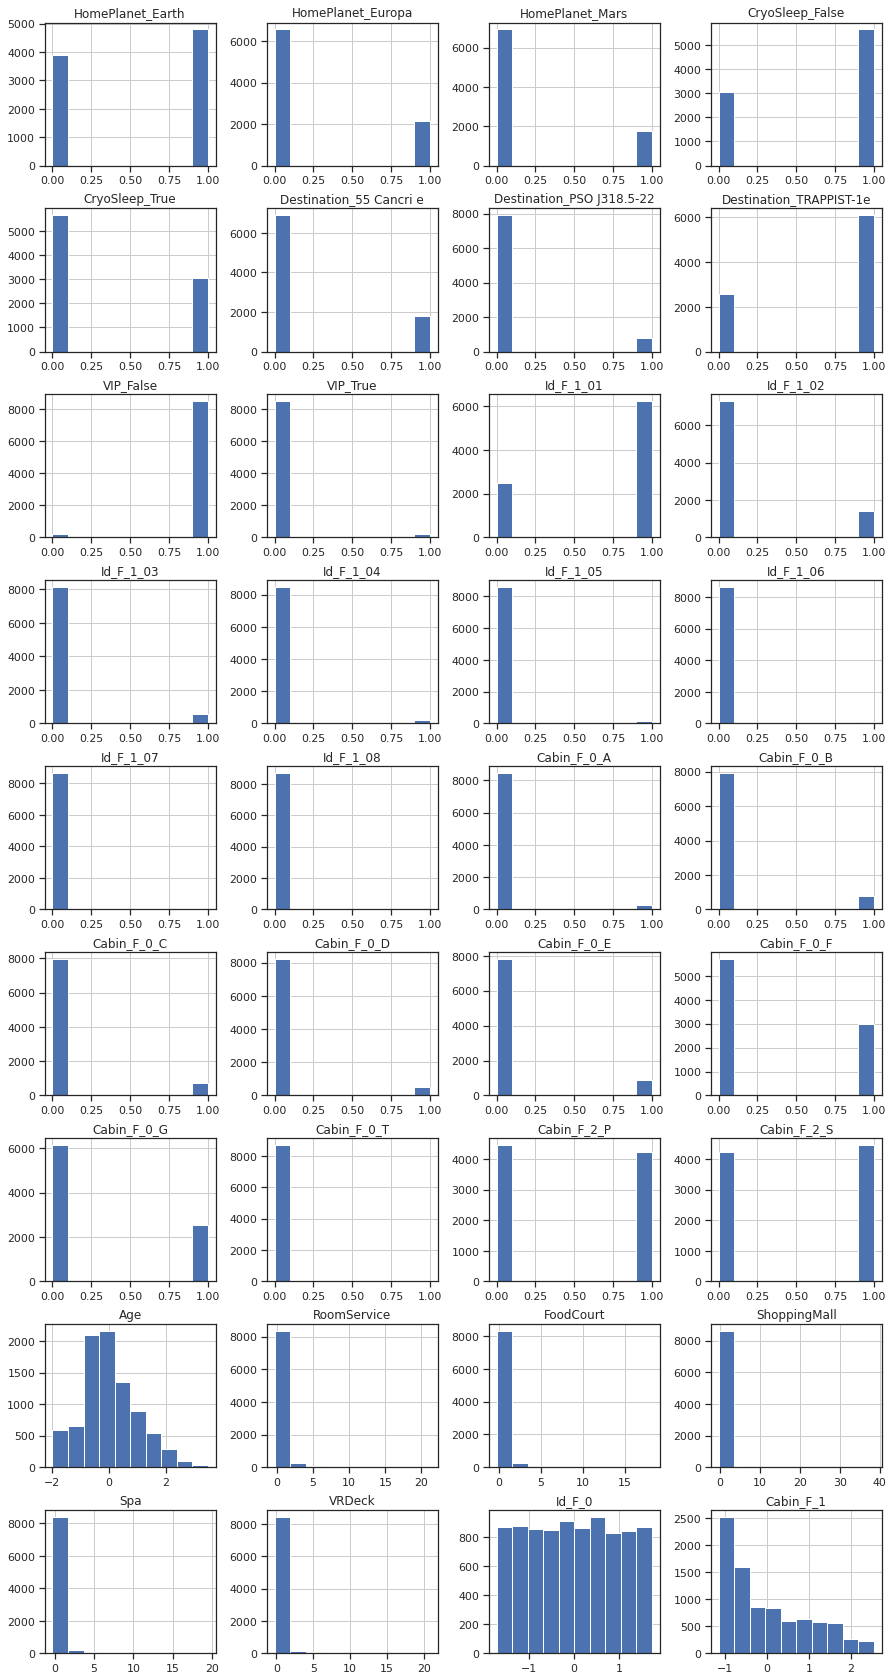

In [25]:
train_data.hist(figsize=(15,30), layout=(9,4))
print("")

Don't think there is a relatioship between `id_F_0` and Target but choose to leave it be at this time.

## Keras Model

Using functional API to build an unnecessarily big model. Adding dropout and Ridge regularization to tackle overfit.

In [26]:
passengers = keras.Input(shape=(train_data.shape[1],), name="passenger")

mid_layers = keras.layers.Dense(2048,
                                kernel_regularizer= keras.regularizers.l2(0.003),
                                activation="relu")(passengers)
mid_layers = keras.layers.Dropout(0.3)(mid_layers)

mid_layers = keras.layers.Dense(2048,
#                                 kernel_regularizer= keras.regularizers.l2(0.003),
                                activation="relu")(mid_layers)
# mid_layers = keras.layers.Dropout(0.3)(mid_layers)

mid_layers = keras.layers.Dense(2048,
                                kernel_regularizer= keras.regularizers.l2(0.003),
                                activation="relu")(mid_layers)
mid_layers = keras.layers.Dropout(0.3)(mid_layers)

# mid_layers = keras.layers.Dense(1024,
#                                 kernel_regularizer= keras.regularizers.l2(0.001),
#                                 activation="relu")(mid_layers)
# mid_layers = keras.layers.Dropout(0.2)(mid_layers)

vitals = keras.layers.Dense(1, activation="sigmoid", name="vitals")(mid_layers)

2022-07-17 21:00:11.985527: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Earlier, it was noted that validation loss starts to "oscillate" durling later epochs when the learning rate is high. Thus, defined a callback to reduce the rate every 10 epochs.

In [27]:
def scheduler(epoch, lr):
    if (epoch > 0) & (epoch % 10 == 0):
        return lr / 2
    else:
        return lr
callback = keras.callbacks.LearningRateScheduler(scheduler, 1)

In [28]:
epochs_num = 60
model = keras.Model(inputs=passengers, outputs=vitals)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss="BinaryCrossentropy", metrics=["accuracy"])

history = model.fit(
    train_data, train_target, batch_size=4300, epochs=epochs_num,
    validation_split=.25, shuffle=True, callbacks = [callback])

2022-07-17 21:00:12.322907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2/2 [==============================] - 4s 1s/step - loss: 6.6019 - accuracy: 0.5324 - val_loss: 14.1749 - val_accuracy: 0.4793
Epoch 2/60

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2/2 [==============================] - 3s 1s/step - loss: 9.9871 - accuracy: 0.5120 - val_loss: 4.2761 - val_accuracy: 0.6366
Epoch 3/60

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2/2 [==============================] - 3s 1s/step - loss: 4.1842 - accuracy: 0.6134 - val_loss: 3.6002 - val_accuracy: 0.8027
Epoch 4/60

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2/2 [==============================] - 3s 1s/step - loss: 3.5362 - accuracy: 0.7615 - val_loss: 3.1250 - val_accuracy: 0.7723
Epoch 5/60

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2/2 [===============

In [29]:
for _ in range(5):
    sample = train_data.sample(4000)
    # train_target[sample.index]
    model.evaluate(sample, train_target[sample.index])

125/125 [==============================] - 2s 13ms/step - loss: 0.6858 - accuracy: 0.7875


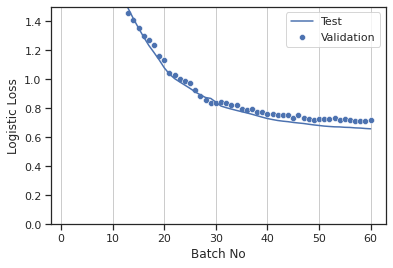

In [30]:
loss = history.history["loss"].copy()
val_loss = history.history["val_loss"].copy()
g_loss = sns.lineplot(x = range(1, len(loss)+1), y=loss, label="Test")
sns.scatterplot(x = range(1, len(loss)+1), y=val_loss, ax=g_loss, label="Validation")
g_loss.set_ylim(0,1.5)
g_loss.set_ylabel("Logistic Loss")
g_loss.set_xlabel("Batch No")
g_loss.set_xticks(range(0, epochs_num+10, 10))
g_loss.grid(True, axis="x")

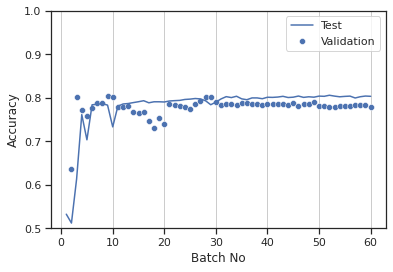

In [31]:
acc = history.history["accuracy"].copy()
val_acc = history.history["val_accuracy"].copy()
g_acc = sns.lineplot(x = range(1, len(acc)+1), y=acc, label="Test")
sns.scatterplot(x = range(1, len(acc)+1), y=val_acc, ax=g_acc, label="Validation")
g_acc.set_ylim(0.5,1)
g_acc.set_ylabel("Accuracy")
g_acc.set_xlabel("Batch No")
g_acc.set_xticks(range(0, epochs_num+10, 10))
g_acc.grid(True, axis="x")

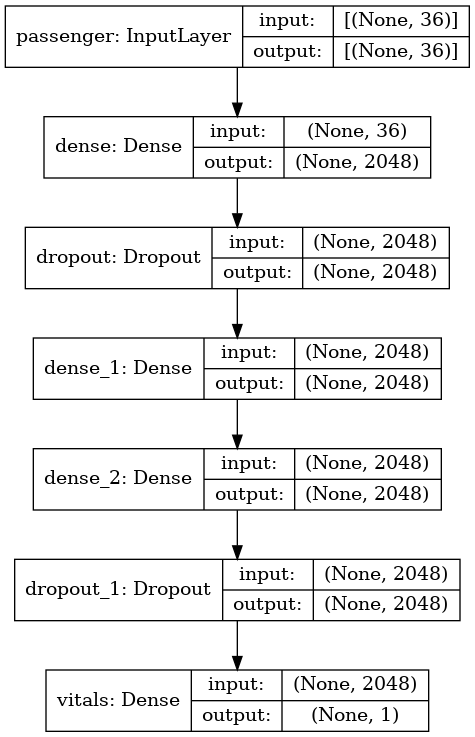

In [32]:
keras.utils.plot_model(model, show_shapes=True)

## Submission

In [33]:
predict = model.predict(test_data)
predict = pd.Series(predict.reshape(-1,))

In [34]:
predict = predict.apply(lambda x: True if x>=.5 else False)
predict.value_counts()

True     2183
False    2094
dtype: int64

In [35]:
submit = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
submit["Transported"] = predict

In [36]:
submit.to_csv("submission.csv", index=False)
submit

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [37]:
model.save("version10.keras")